In [124]:
from statsforecast import StatsForecast
from statsforecast.models import (Naive, SeasonalNaive, AutoARIMA)
from datasetsforecast.losses import mse, mae, smape
from data_loading_finance.loading_data import LoadingData
from ts_tools.tools import tools
import yfinance as yf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore


from typing import List, Callable
from distributed import Client
from fugue import transform
from fugue_dask import DaskExecutionEngine

import warnings
warnings.filterwarnings("ignore")

In [111]:
# Descargar datos
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'IBM', 'BTC-USD']
Y_df = yf.download(tickers, start='2019-01-01', end='2023-12-31', interval='1mo')['Adj Close']

# Resetear el índice y transformar el DataFrame
Y_df = Y_df.reset_index().melt(id_vars='Date', var_name='unique_id', value_name='y')
Y_df = Y_df.rename(columns={'Date': 'ds'})

# Calcular los retornos
Y_df['y'] = np.log(Y_df['y'].div(Y_df.groupby('unique_id')['y'].shift(1)))
Y_df = Y_df.dropna(subset=['y']).reset_index(drop=True)

[*********************100%%**********************]  8 of 8 completed


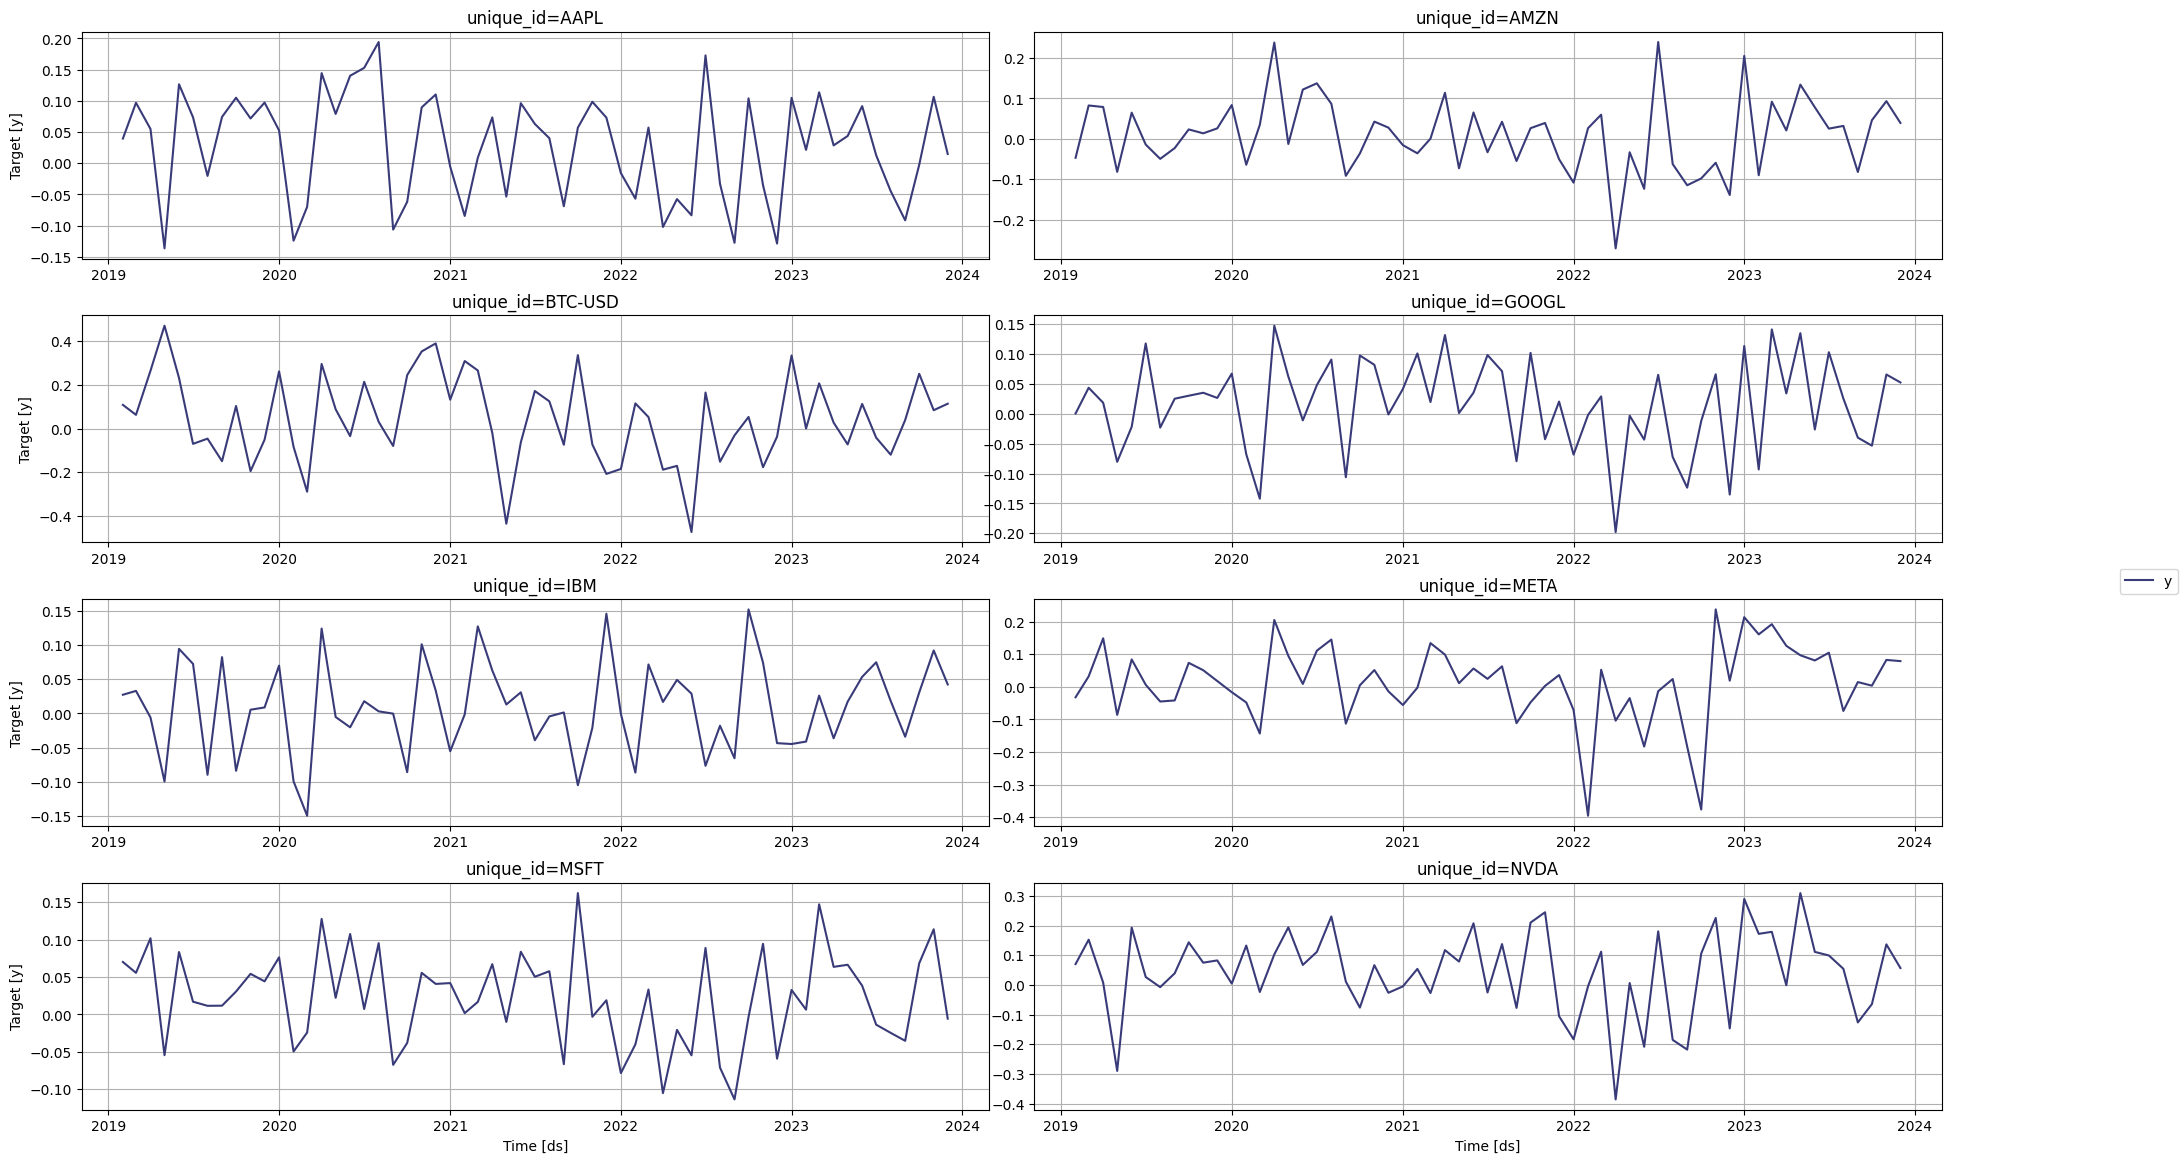

In [112]:
StatsForecast.plot(Y_df)

In [125]:
season_length=12
horizon = 3

models = [
    AutoARIMA(season_length=season_length),
    SeasonalNaive(season_length=season_length),
]

# Instantiate StatsForecast class with models, data frequency ('MS' for monthly),
# and parallel computation on all CPU cores (n_jobs=-1)
sf = StatsForecast(
    models=models, # models for forecasting
    freq='MS',  # frequency of the data
    n_jobs=1  # number of jobs to run in parallel, -1 means using all processors
)

In [127]:
# Generate forecasts for the specified horizon using the sf object
Y_hat_df = sf.forecast(df=Y_df, h=horizon) # forecast data
Y_hat_df.head() 

,ds,AutoARIMA,SeasonalNaive
unique_id,,,
AAPL,2024-01-01,0.021517,0.104829
AAPL,2024-02-01,0.004391,0.021393
AAPL,2024-03-01,0.023327,0.113647
AMZN,2024-01-01,0.000000,0.205174
AMZN,2024-02-01,0.000000,-0.090252


In [128]:
cv_df = sf.cross_validation(df=Y_df, h=horizon, n_windows=10, step_size=horizon, level=[90])
cv_df.head()

,ds,cutoff,y,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90,SeasonalNaive,SeasonalNaive-lo-90,SeasonalNaive-hi-90
unique_id,,,,,,,,,
AAPL,2021-07-01,2021-06-01,0.062958,0.000000,-0.160620,0.160620,0.152834,-0.049880,0.355548
AAPL,2021-08-01,2021-06-01,0.040114,0.000000,-0.160620,0.160620,0.194233,-0.008481,0.396948
AAPL,2021-09-01,2021-06-01,-0.068965,0.000000,-0.160620,0.160620,-0.106370,-0.309084,0.096344
AAPL,2021-10-01,2021-09-01,0.057002,-0.029591,-0.180195,0.121013,-0.061888,-0.260444,0.136667
AAPL,2021-11-01,2021-09-01,0.098461,0.000000,-0.160290,0.160290,0.089481,-0.109075,0.288036


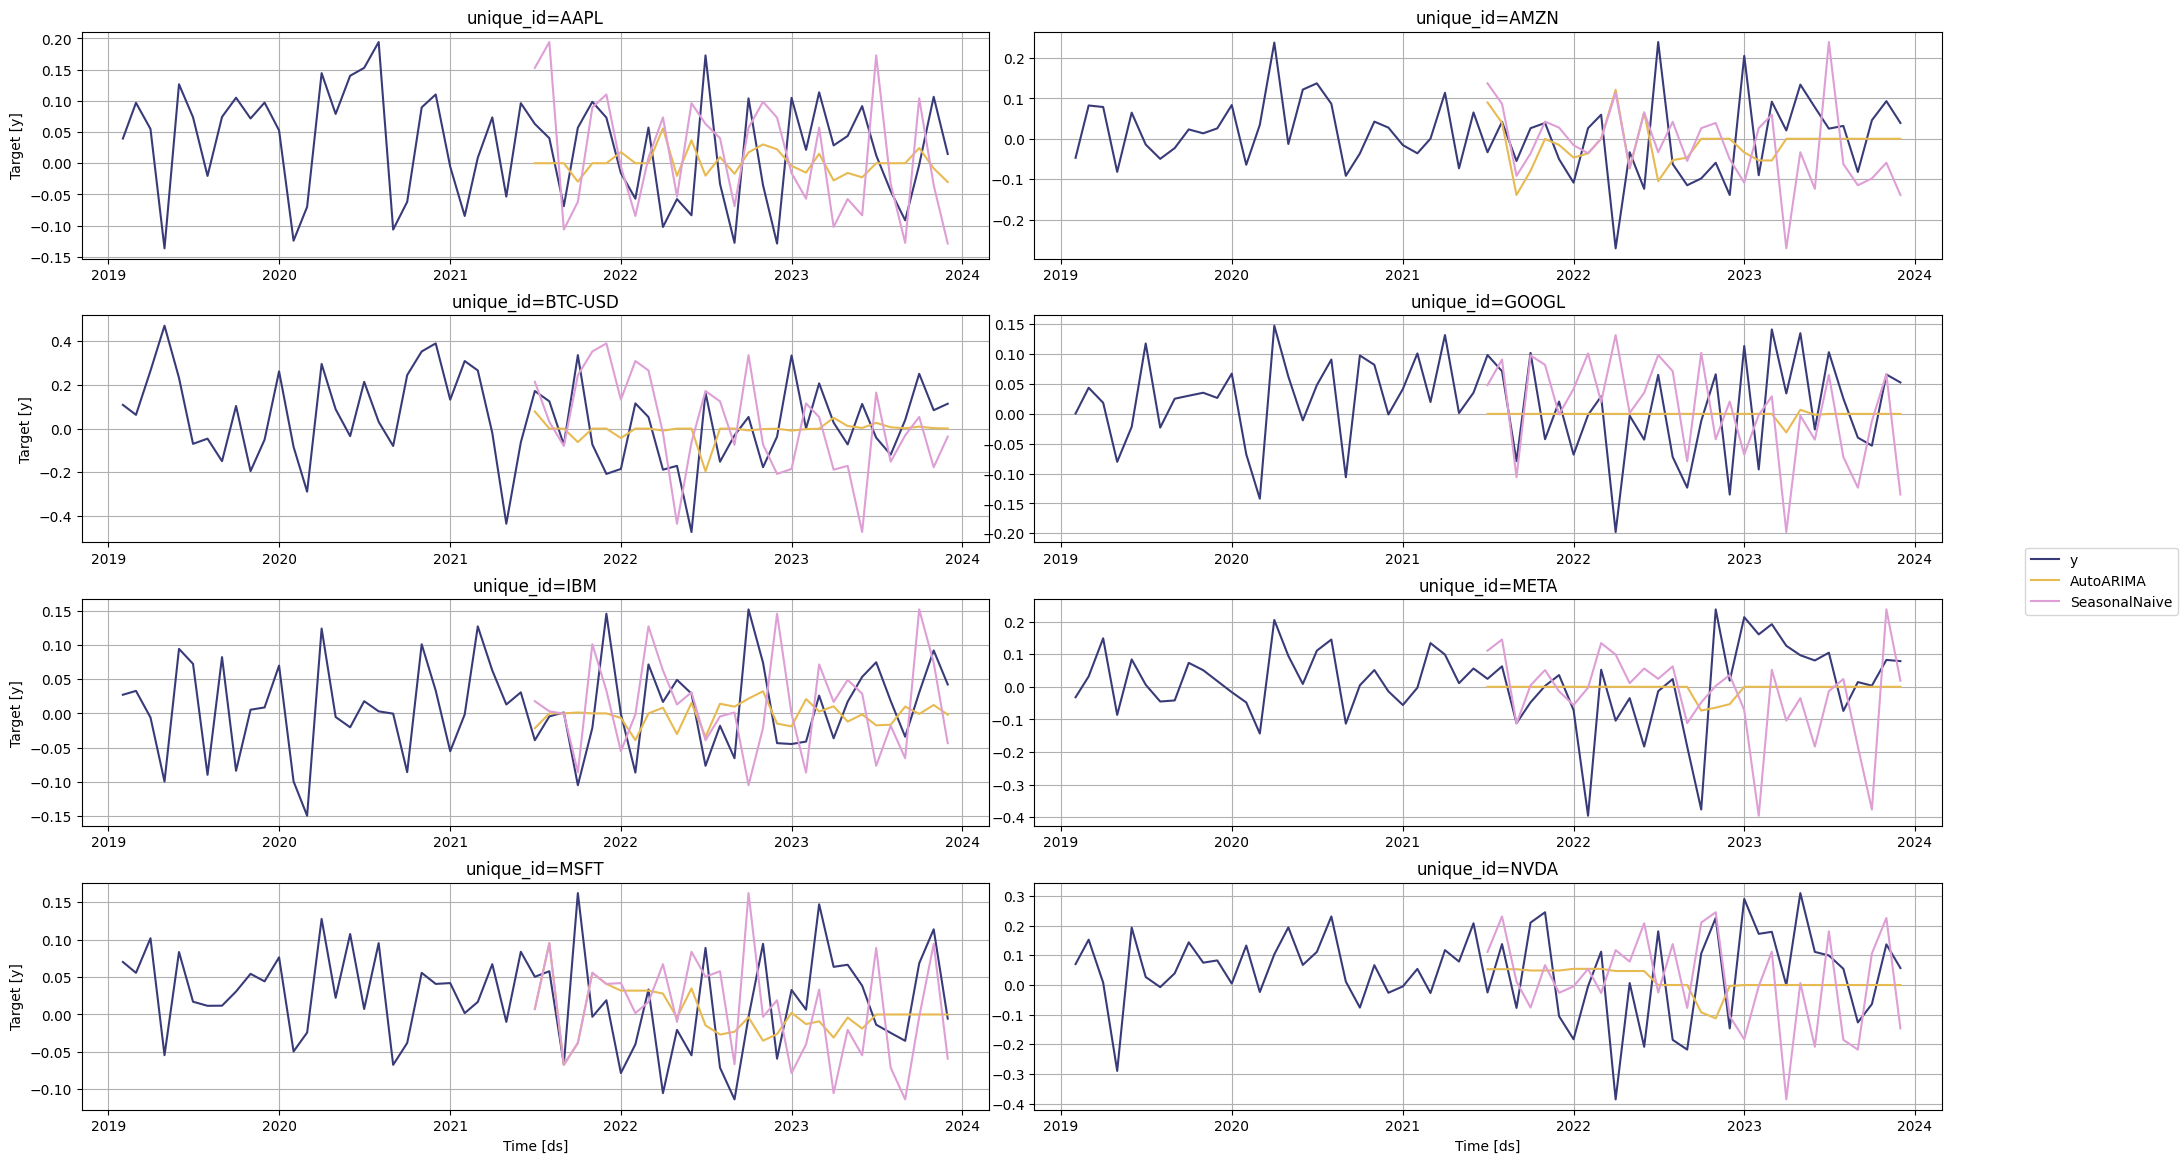

In [129]:
StatsForecast.plot(Y_df, cv_df.drop(['cutoff', 'y'], axis=1))